## Import the necessary library


In [1]:
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
env = UnityEnvironment(file_name='./Crawler_Windows_x86_64/Crawler.exe')
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: CrawlerBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 129
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 20
        Vector Action descriptions: , , , , , , , , , , , , , , , , , , , 


### Method to plot the progress of the agent's score

In [4]:
def plot_result(scores):
    # plot the scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

## Validation method
The noise has to be deactivated before the validation. This method is being used to assess the performance of the agent after every episode of training

In [5]:
def validate(agent, max_t, train_mode=True):
    env_info = env.reset(train_mode=train_mode)[brain_name]
    states = env_info.vector_observations
    scores_one_episode = np.zeros(states.shape[0])
    for t in range(max_t):
        actions, _, _ = agent.act(states)                        # select an action (for each agent)
        env_info = env.step(np.clip(actions, -1, 1))[brain_name]   # send all actions to the environment
        next_states = env_info.vector_observations               # get next state (for each agent)
        rewards = env_info.rewards                               # get reward (for each agent)
        dones = env_info.local_done                              # see if episode finished
        scores_one_episode += env_info.rewards                   # update the score (for each agent)
        states = next_states                                     # roll over states to next time step
        if np.any(dones):                                        # exit loop if episode finished
            break
    return scores_one_episode

## Training method
The main loop of the training can be found here

In [98]:
def train(agent, n_episodes=500, max_t=500, train_mode=True):
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name]
        states = env_info.vector_observations
        scores_one_episode = np.zeros(states.shape[0])
        trajectories_states, trajectories_actions, trajectories_log_probs, trajectories_values, \
        trajectories_rewards, trajectories_next_states, trajectories_dones = [],[],[],[],[],[],[]
        
        for t in range(max_t):
            actions, log_probs, values = agent.act(states)
            env_info = env.step(np.clip(actions, -1, 1))[brain_name] # send all actions to the environment
            next_states = env_info.vector_observations               # get next state (for each agent)
            rewards = env_info.rewards                               # get reward (for each agent)
            dones = env_info.local_done                              # see if episode finished
            scores_one_episode += rewards
            trajectories_states.append(states)
            trajectories_actions.append(actions)
            trajectories_log_probs.append(log_probs)
            trajectories_values.append(values)
            trajectories_rewards.append(rewards)
            trajectories_next_states.append(next_states)
            trajectories_dones.append(dones)
            states = next_states                                     # roll over states to next time step
            if np.any(dones):                                        # exit loop if episode finished
                break
#                 env_info = env.reset(train_mode=train_mode)[brain_name]
#                 states = env_info.vector_observations 
  
        agent.learn(trajectories_states, trajectories_actions, trajectories_log_probs, trajectories_values, 
        trajectories_rewards, trajectories_next_states, trajectories_dones)
        score = np.average(scores_one_episode)
        scores.append(score)
        scores_window.append(score)
        mean_100 = np.mean(scores_window)
        if i_episode % 50 == 0:
            print('\rEpisode {}\tAverage Score: {:.3f}\tMin Score: {:.3f}\tMax Score: {:.3f}'.format(i_episode, mean_100, 
                                                                                                     np.min(np.array(scores_window)[-50:]),
                                                                                                     np.max(np.array(scores_window)[-50:])))
            agent.save("ppo_" + str(i_episode) + ".pth")
        if len(scores_window) >= 100 and np.mean(scores_window)>=300:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode, mean_100))
            agent.save("ppo_final.pth")
            break
    return scores

In [95]:
from agents.ppo import PPO
from agents.model_ppo import Gaussian
import random
import torch.nn.functional as F

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
states = env_info.vector_observations
action_size = brain.vector_action_space_size
network = Gaussian(states.shape[1], action_size, activation=F.leaky_relu).to(device)
agent = PPO(network, device,
                 LR=1e-4,
                 GRADIENT_CLIP=5, 
                 EPOCHS=3, 
                 BATCH_SIZE=128,
                GAMMA=0.99,
                GAE_TAU=0.99,
                CLIP_EPSILON=0.05)
agent.save("random.pth")
scores = train(agent, n_episodes=60000, max_t=1010, train_mode=True)
plot_result(scores)

Episode 50	Average Score: 0.831	Min Score: -0.939	Max Score: 3.695


KeyboardInterrupt: 

## Continue the training

Episode 50	Average Score: 259.674	Min Score: 14.266	Max Score: 1065.437
Episode 100	Average Score: 241.788	Min Score: 14.802	Max Score: 767.787
Episode 150	Average Score: 189.214	Min Score: 17.708	Max Score: 1073.731
Episode 200	Average Score: 164.676	Min Score: 22.781	Max Score: 630.044
Episode 250	Average Score: 159.569	Min Score: 14.035	Max Score: 566.014
Episode 300	Average Score: 148.102	Min Score: 16.360	Max Score: 450.952
Episode 350	Average Score: 157.552	Min Score: 19.578	Max Score: 828.721
Episode 400	Average Score: 157.803	Min Score: 21.186	Max Score: 602.594
Episode 450	Average Score: 163.527	Min Score: 20.279	Max Score: 768.095
Episode 500	Average Score: 160.226	Min Score: 16.151	Max Score: 738.947
Episode 550	Average Score: 164.872	Min Score: 24.782	Max Score: 708.046
Episode 600	Average Score: 162.707	Min Score: 13.532	Max Score: 628.129
Episode 650	Average Score: 167.586	Min Score: 12.442	Max Score: 729.070
Episode 700	Average Score: 169.481	Min Score: 15.460	Max Score:

Episode 5800	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 5850	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 5900	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 5950	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 6000	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 6050	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 6100	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 6150	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 6200	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 6250	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 6300	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 6350	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 6400	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 6450	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episod

Episode 11550	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 11600	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 11650	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 11700	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 11750	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 11800	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 11850	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 11900	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 11950	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 12000	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 12050	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 12100	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 12150	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 12200	Average Score: -0.575	Min Score: -0.575	Max Score:

Episode 17250	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 17300	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 17350	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 17400	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 17450	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 17500	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 17550	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 17600	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 17650	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 17700	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 17750	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 17800	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 17850	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 17900	Average Score: -0.575	Min Score: -0.575	Max Score:

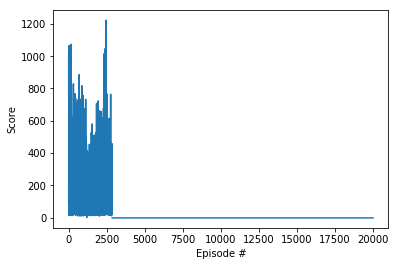

In [99]:
# agent.load("weights\ppo_2500.pth")
scores = train(agent, n_episodes=20000, max_t=1010, train_mode=True)
plot_result(scores)

In [103]:
agent.load("weights\\112x112(4)\\ppo_2900.pth")
for param in agent.network.parameters():
    print(param.data)

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan]])
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, n

In [74]:
a = torch.tensor(np.ones((1,12)))
print(a.shape)
print(a.squeeze().shape)

torch.Size([1, 12])
torch.Size([12])


## View the trained agent
Use the cell below to load and view a trained agent

In [53]:
def getRandomAgent():
    states = env_info.vector_observations
    action_size = brain.vector_action_space_size
    network = Gaussian(states.shape[1], action_size, activation=F.leaky_relu).to(device)
    agent = PPO(network, device,
                     LR=3e-4,
                     GRADIENT_CLIP=5, 
                     EPOCHS=4, 
                     BATCH_SIZE=128,
                    GAMMA=0.99,
                    GAE_TAU=0.99,
                    CLIP_EPSILON=0.1)
    agent.save("random.pth")
    return agent

In [62]:
randomAgent = getRandomAgent()
for i in range(10):
    scores = validate(agent, 1000, False)
    print(np.mean(scores))

4.782412864151411
6.451264345087111
3.053201584572283
5.67499509997045
0.5141821877720455
0.5915440870448947
0.6432088414827982
8.565833345404826
2.755592852520446
7.675711660296656


In [97]:
agent.load("weights\\112x112(3)\\ppo_final.pth")
for i in range(10):
    scores = validate(agent, 1000, False)
    print(np.mean(scores))

1029.6468797972193
71.46703152226594
369.79313709047466
152.63671926905712
26.733997968180727
54.89458779113678
62.532700395172775
234.19829111732543
69.8472391878119
110.33540159254335
